<a href="https://colab.research.google.com/github/wrymp/Final-Project-Walmart-Recruiting---Store-Sales-Forecasting/blob/main/model_experiment_DLinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLinear Implementation for Walmart Sales Forecasting - FIXED VERSION

This notebook contains a complete, working DLinear model implementation for Walmart sales forecasting.
All issues from the original version have been fixed.

**DLinear** is a simple but effective time series model that:
- Decomposes input into trend and seasonal components
- Uses linear layers on each component separately
- Combines results for final prediction

## Key Fixes Applied:
1. ✅ Fixed configuration syntax errors
2. ✅ Added data sparsity handling
3. ✅ Robust dataset class with validation
4. ✅ Safe cross-validation implementation
5. ✅ Comprehensive error handling

In [5]:
from google.colab import drive
!pip install wandb -q
!pip install kaggle -q

drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Uncomment to download data if needed\n",
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip /content/walmart-recruiting-store-sales-forecasting.zip
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip
!unzip /content/features.csv.zip
!unzip /content/sampleSubmission.csv.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 818MB/s]
Archive:  /content/walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/features.csv.zip
  inflating: features.csv            
Archive:  /content/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


## 1. Setup and Installation

In [6]:
# Install required packages
import subprocess
import sys

def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Uncomment if running in Google Colab
# from google.colab import drive
# install_if_missing('wandb')
# install_if_missing('kaggle')

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import json
from datetime import datetime, timedelta
import os
import wandb

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
wandb.login()
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (dshan21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


## 2. Data Loading Functions

In [8]:
def create_sample_data():
    """
    Create sample Walmart-like data for testing if actual data is not available
    """
    print("Creating sample data for testing...")

    # Date range
    start_date = pd.to_datetime('2010-02-05')
    end_date = pd.to_datetime('2012-10-26')
    dates = pd.date_range(start=start_date, end=end_date, freq='W-FRI')

    # Sample configuration
    stores = list(range(1, 46))  # 45 stores
    departments = list(range(1, 82))  # 81 departments

    # Create data (not all store-dept combinations exist)
    data = []
    np.random.seed(42)

    for store in stores:
        # Each store has 60-80% of departments
        store_depts = np.random.choice(departments, size=int(0.7 * len(departments)), replace=False)

        for dept in store_depts:
            for date in dates:
                # Some random missing data
                if np.random.random() > 0.95:
                    continue

                # Generate realistic sales data
                base_sales = np.random.lognormal(8, 1)
                seasonal_effect = 1 + 0.3 * np.sin(2 * np.pi * date.dayofyear / 365)
                holiday_effect = 1.2 if np.random.random() > 0.9 else 1.0

                weekly_sales = base_sales * seasonal_effect * holiday_effect

                data.append({
                    'Store': store,
                    'Dept': dept,
                    'Date': date,
                    'Weekly_Sales': weekly_sales,
                    'IsHoliday': holiday_effect > 1.0
                })

    df = pd.DataFrame(data)

    # Add features
    df['Temperature'] = 40 + 30 * np.sin(2 * np.pi * df['Date'].dt.dayofyear / 365) + np.random.normal(0, 5, len(df))
    df['Fuel_Price'] = 3.0 + 0.5 * np.random.normal(0, 1, len(df))
    df['CPI'] = 200 + np.random.normal(0, 10, len(df))
    df['Unemployment'] = 8 + np.random.normal(0, 2, len(df))
    df['Type'] = np.random.choice(['A', 'B', 'C'], len(df))
    df['Size'] = np.random.choice([50000, 75000, 100000, 125000], len(df))

    # Fill markdown columns with mostly zeros (realistic)
    for i in range(1, 6):
        df[f'MarkDown{i}'] = np.where(np.random.random(len(df)) > 0.8,
                                      np.random.exponential(1000), 0)

    print(f"Sample data created: {len(df)} rows, {df['Store'].nunique()} stores, {df['Dept'].nunique()} departments")
    return df

In [9]:
def load_walmart_data():
    """
    Load actual Walmart data if available, otherwise create sample data
    """
    try:
        # Try to load actual data
        train_df = pd.read_csv('train.csv')
        features_df = pd.read_csv('features.csv')
        stores_df = pd.read_csv('stores.csv')

        print("Loaded actual Walmart data")
        return train_df, features_df, stores_df

    except FileNotFoundError:
        print("Actual data files not found, creating sample data...")
        sample_df = create_sample_data()

        # Split sample data into components to match expected structure
        train_df = sample_df[['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']].copy()

        features_df = sample_df.groupby(['Store', 'Date']).agg({
            'Temperature': 'first',
            'Fuel_Price': 'first',
            'CPI': 'first',
            'Unemployment': 'first',
            'MarkDown1': 'first',
            'MarkDown2': 'first',
            'MarkDown3': 'first',
            'MarkDown4': 'first',
            'MarkDown5': 'first',
            'IsHoliday': 'first'
        }).reset_index()

        stores_df = sample_df.groupby('Store').agg({
            'Type': 'first',
            'Size': 'first'
        }).reset_index()

        return train_df, features_df, stores_df

# Load data
train_df, features_df, stores_df = load_walmart_data()

print(f"Train data shape: {train_df.shape}")
print(f"Features data shape: {features_df.shape}")
print(f"Stores data shape: {stores_df.shape}")

Loaded actual Walmart data
Train data shape: (421570, 5)
Features data shape: (8190, 12)
Stores data shape: (45, 3)


## 3. Data Preprocessing

In [10]:
def preprocess_walmart_data(train_df, features_df, stores_df, min_sequences_per_combination=15):
    """
    Comprehensive data preprocessing with sparsity handling
    """
    print("=== Data Preprocessing ===")

    # Merge all datasets
    train_merged = train_df.merge(features_df, on=['Store', 'Date'], how='left')
    train_merged = train_merged.merge(stores_df, on='Store', how='left')

    # Convert Date to datetime
    train_merged['Date'] = pd.to_datetime(train_merged['Date'])

    # Sort by Store, Dept, Date
    train_merged = train_merged.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

    # Create time-based features
    train_merged['Year'] = train_merged['Date'].dt.year
    train_merged['Month'] = train_merged['Date'].dt.month
    train_merged['Week'] = train_merged['Date'].dt.isocalendar().week
    train_merged['DayOfYear'] = train_merged['Date'].dt.dayofyear
    train_merged['Quarter'] = train_merged['Date'].dt.quarter

    # Handle holiday columns (might have different names from merge)
    holiday_cols = [col for col in train_merged.columns if 'holiday' in col.lower()]
    if len(holiday_cols) > 1:
        # Combine holiday indicators
        train_merged['IsHoliday'] = train_merged[holiday_cols].any(axis=1).astype(int)
        # Drop duplicate holiday columns
        train_merged = train_merged.drop(columns=holiday_cols[1:])
    elif len(holiday_cols) == 1:
        train_merged['IsHoliday'] = train_merged[holiday_cols[0]].astype(int)

    # Fill missing values
    numeric_columns = train_merged.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if col != 'Weekly_Sales':  # Don't fill target variable
            train_merged[col] = train_merged[col].fillna(train_merged[col].median())

    # Encode categorical variables
    if 'Type' in train_merged.columns:
        le_type = LabelEncoder()
        train_merged['Type'] = le_type.fit_transform(train_merged['Type'].fillna('Unknown'))

    # Analyze store-department combinations
    combination_stats = train_merged.groupby(['Store', 'Dept']).agg({
        'Date': ['count', 'min', 'max'],
        'Weekly_Sales': ['mean', 'std', 'count']
    }).reset_index()

    combination_stats.columns = ['Store', 'Dept', 'count', 'date_min', 'date_max',
                                'sales_mean', 'sales_std', 'sales_count']

    print(f"Total store-department combinations: {len(combination_stats)}")
    print(f"Data points per combination - Min: {combination_stats['count'].min()}, Max: {combination_stats['count'].max()}")

    # Filter combinations with sufficient data
    sufficient_combinations = combination_stats[combination_stats['count'] >= min_sequences_per_combination]
    print(f"Combinations with >= {min_sequences_per_combination} data points: {len(sufficient_combinations)}")

    # Keep only combinations with sufficient data
    keep_combinations = set(zip(sufficient_combinations['Store'], sufficient_combinations['Dept']))
    train_filtered = train_merged[
        train_merged[['Store', 'Dept']].apply(tuple, axis=1).isin(keep_combinations)
    ].copy()

    print(f"Filtered data shape: {train_filtered.shape} (was {train_merged.shape})")

    # Remove rows with missing target values
    train_filtered = train_filtered.dropna(subset=['Weekly_Sales'])

    print(f"Final data shape after removing missing targets: {train_filtered.shape}")

    return train_filtered, combination_stats

# Preprocess data
train_processed, combination_stats = preprocess_walmart_data(train_df, features_df, stores_df)

# Define feature columns
exclude_cols = ['Weekly_Sales', 'Date', 'Store', 'Dept']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]
print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

=== Data Preprocessing ===
Total store-department combinations: 3331
Data points per combination - Min: 1, Max: 143
Combinations with >= 15 data points: 3121
Filtered data shape: (420389, 22) (was (421570, 22))
Final data shape after removing missing targets: (420389, 22)
Feature columns (18): ['IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week', 'DayOfYear', 'Quarter', 'IsHoliday']


## 4. Robust Time Series Dataset

In [11]:
class TimeSeriesDatasetRobust(Dataset):
    """
    Robust TimeSeriesDataset with comprehensive validation and error handling
    """

    def __init__(self, data, target_col, feature_cols, sequence_length, prediction_length,
                 store_col='Store', dept_col='Dept', min_sequences=1, verbose=True):
        self.data = data.copy()
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.store_col = store_col
        self.dept_col = dept_col
        self.min_sequences = min_sequences
        self.verbose = verbose

        # Sort data properly
        self.data = self.data.sort_values([store_col, dept_col, 'Date']).reset_index(drop=True)

        # Create sequences with comprehensive validation
        self.sequences = self._create_sequences_with_validation()

        if self.verbose:
            print(f"TimeSeriesDataset created: {len(self.sequences)} sequences from {len(data)} data points")

    def _create_sequences_with_validation(self):
        sequences = []
        skipped_combinations = 0
        total_combinations = 0

        required_length = self.sequence_length + self.prediction_length

        for (store, dept), group in self.data.groupby([self.store_col, self.dept_col]):
            total_combinations += 1
            group = group.sort_values('Date').reset_index(drop=True)

            # Validate group has enough data
            if len(group) < required_length:
                skipped_combinations += 1
                if self.verbose and total_combinations <= 5:  # Show first few warnings
                    print(f"  Warning: Store {store}, Dept {dept} has only {len(group)} points, need {required_length}")
                continue

            # Check for missing values in critical columns
            if group[self.target_col].isnull().any():
                skipped_combinations += 1
                continue

            # Create sequences for this store-department combination
            combination_sequences = 0
            for i in range(len(group) - required_length + 1):
                input_data = group.iloc[i:i + self.sequence_length]
                target_data = group.iloc[i + self.sequence_length:i + self.sequence_length + self.prediction_length]

                # Validate sequence integrity
                if (len(input_data) == self.sequence_length and
                    len(target_data) == self.prediction_length and
                    not input_data[self.target_col].isnull().any() and
                    not target_data[self.target_col].isnull().any()):

                    # Prepare feature data (fill any remaining NaNs)
                    input_features = input_data[self.feature_cols].fillna(0).values.astype(np.float32)

                    sequences.append({
                        'input_features': input_features,
                        'input_target': input_data[self.target_col].values.astype(np.float32),
                        'target': target_data[self.target_col].values.astype(np.float32),
                        'store': store,
                        'dept': dept,
                        'start_date': input_data['Date'].iloc[0],
                        'end_date': target_data['Date'].iloc[-1]
                    })
                    combination_sequences += 1

            # Check minimum sequences per combination
            if combination_sequences < self.min_sequences:
                # Remove sequences from this combination
                sequences = [s for s in sequences if not (s['store'] == store and s['dept'] == dept)]
                skipped_combinations += 1

        if self.verbose:
            print(f"  Total combinations processed: {total_combinations}")
            print(f"  Combinations skipped: {skipped_combinations}")
            print(f"  Valid sequences created: {len(sequences)}")

        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {
            'input_features': torch.FloatTensor(seq['input_features']),
            'input_target': torch.FloatTensor(seq['input_target']),
            'target': torch.FloatTensor(seq['target'])
        }

## 5. DLinear Model Implementation

In [12]:
class MovingAvg(nn.Module):
    """Moving average block to highlight the trend of time series"""
    def __init__(self, kernel_size, stride):
        super(MovingAvg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # Padding on both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class SeriesDecomp(nn.Module):
    """Series decomposition block"""
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    DLinear model implementation
    Paper: Are Transformers Effective for Time Series Forecasting?
    """
    def __init__(self, seq_len, pred_len, enc_in, individual=False, kernel_size=25):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.individual = individual
        self.channels = enc_in

        # Decomposition
        self.decomposition = SeriesDecomp(kernel_size)

        if self.individual:
            # Individual linear layers for each channel
            self.Linear_Seasonal = nn.ModuleList([
                nn.Linear(self.seq_len, self.pred_len) for _ in range(self.channels)
            ])
            self.Linear_Trend = nn.ModuleList([
                nn.Linear(self.seq_len, self.pred_len) for _ in range(self.channels)
            ])
        else:
            # Shared linear layers
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)

        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len],
                                        dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len],
                                     dtype=trend_init.dtype).to(trend_init.device)

            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)  # [Batch, Output length, Channel]

## 6. Training Functions

In [13]:
def create_dataloaders_safe(train_data, val_data, feature_cols, sequence_length, prediction_length, batch_size=32):
    """Create data loaders with comprehensive safety checks"""

    print(f"Creating dataloaders:")
    print(f"  Sequence length: {sequence_length}")
    print(f"  Prediction length: {prediction_length}")
    print(f"  Batch size: {batch_size}")
    print(f"  Train data: {len(train_data)} rows")
    print(f"  Val data: {len(val_data)} rows")

    # Create datasets
    train_dataset = TimeSeriesDatasetRobust(
        train_data, 'Weekly_Sales', feature_cols, sequence_length, prediction_length, verbose=True
    )

    val_dataset = TimeSeriesDatasetRobust(
        val_data, 'Weekly_Sales', feature_cols, sequence_length, prediction_length, verbose=True
    )

    # Validate datasets
    if len(train_dataset) == 0:
        print("ERROR: Training dataset is empty!")
        return None, None

    if len(val_dataset) == 0:
        print("ERROR: Validation dataset is empty!")
        return None, None

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"  Train loader: {len(train_loader)} batches ({len(train_dataset)} sequences)")
    print(f"  Val loader: {len(val_loader)} batches ({len(val_dataset)} sequences)")

    return train_loader, val_loader

In [14]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device, config_name="model", wandb_run=None):
    """Train the DLinear model with comprehensive monitoring and optional WandB logging"""

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None

    print(f"Training {config_name} for {num_epochs} epochs...")

    # Log training hyperparameters if wandb_run is provided
    if wandb_run:
        wandb_run.log({
            f"{config_name}/num_epochs": num_epochs,
            f"{config_name}/learning_rate": learning_rate,
            f"{config_name}/optimizer": "Adam",
            f"{config_name}/criterion": "MSELoss",
            f"{config_name}/scheduler": "ReduceLROnPlateau"
        })

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        for batch_idx, batch in enumerate(train_loader):
            # Use target history for univariate forecasting
            inputs = batch['input_target'].unsqueeze(-1).to(device)  # [batch, seq_len, 1]
            targets = batch['target'].unsqueeze(-1).to(device)  # [batch, pred_len, 1]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()
            train_batches += 1

            # Log batch-level metrics occasionally (for final model training)
            if wandb_run and config_name == "Final-Model" and batch_idx % 50 == 0:
                wandb_run.log({
                    "batch/train_loss": loss.item(),
                    "batch/epoch": epoch,
                    "batch/batch_idx": batch_idx
                })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_target'].unsqueeze(-1).to(device)
                targets = batch['target'].unsqueeze(-1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_batches += 1

        # Calculate average losses
        avg_train_loss = train_loss / train_batches if train_batches > 0 else float('inf')
        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            if wandb_run:
                wandb_run.log({f"{config_name}/best_epoch": epoch})

        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # Log epoch-level metrics to WandB
        if wandb_run:
            log_dict = {
                f"{config_name}/train_loss": avg_train_loss,
                f"{config_name}/val_loss": avg_val_loss,
                f"{config_name}/learning_rate": new_lr,
                f"{config_name}/best_val_loss": best_val_loss
            }

            if config_name == "Final-Model":
                log_dict["epoch"] = epoch
                wandb_run.log(log_dict, step=epoch)
            else:
                wandb_run.log(log_dict)

            if new_lr != old_lr:
                wandb_run.log({f"{config_name}/lr_reduction_epoch": epoch})

        # Print progress
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Log training summary
    if wandb_run:
        wandb_run.log({
            f"{config_name}/final_train_loss": train_losses[-1],
            f"{config_name}/final_val_loss": val_losses[-1],
            f"{config_name}/best_val_loss": best_val_loss,
            f"{config_name}/total_epochs": num_epochs,
            f"{config_name}/final_lr": optimizer.param_groups[0]['lr']
        })

    return model, train_losses, val_losses, best_val_loss

In [15]:
def evaluate_model(model, test_loader, device):
    """Evaluate the model and return comprehensive metrics"""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_target'].unsqueeze(-1).to(device)
            targets = batch['target'].to(device)

            outputs = model(inputs).squeeze(-1)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate metrics
    mse = mean_squared_error(actuals.flatten(), predictions.flatten())
    mae = mean_absolute_error(actuals.flatten(), predictions.flatten())
    rmse = np.sqrt(mse)

    # MAPE (avoiding division by zero)
    mape = np.mean(np.abs((actuals.flatten() - predictions.flatten()) /
                         np.maximum(np.abs(actuals.flatten()), 1e-8))) * 100

    return {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'predictions': predictions,
        'actuals': actuals
    }

## 7. Time Series Cross-Validation

In [16]:
class TimeSeriesCrossValidator:
    """Time series cross-validator with expanding window approach"""

    def __init__(self, n_splits=3, test_size_weeks=8, gap_weeks=2):
        self.n_splits = n_splits
        self.test_size_weeks = test_size_weeks
        self.gap_weeks = gap_weeks

    def split(self, data, date_col='Date'):
        """Generate train/test splits for time series cross-validation"""
        data_sorted = data.sort_values(date_col).reset_index(drop=True)
        unique_dates = sorted(data_sorted[date_col].unique())
        total_weeks = len(unique_dates)

        print(f"Time series CV: {total_weeks} weeks available, creating {self.n_splits} splits")

        splits = []

        for i in range(self.n_splits):
            # Test end point (working backwards)
            test_end_idx = total_weeks - i * (self.test_size_weeks + self.gap_weeks)
            test_start_idx = test_end_idx - self.test_size_weeks

            # Train end point (with gap)
            train_end_idx = test_start_idx - self.gap_weeks

            if train_end_idx <= 0 or test_start_idx <= 0:
                print(f"Insufficient data for split {i+1}, stopping at {len(splits)} splits")
                break

            # Convert to dates
            train_end_date = unique_dates[train_end_idx - 1]
            test_start_date = unique_dates[test_start_idx]
            test_end_date = unique_dates[test_end_idx - 1]

            # Create boolean masks
            train_mask = data_sorted[date_col] <= train_end_date
            test_mask = (data_sorted[date_col] >= test_start_date) & (data_sorted[date_col] <= test_end_date)

            train_indices = data_sorted[train_mask].index.tolist()
            test_indices = data_sorted[test_mask].index.tolist()

            if len(train_indices) > 0 and len(test_indices) > 0:
                splits.append((train_indices, test_indices))
                print(f"  Split {i+1}: Train weeks 1-{train_end_idx}, Test weeks {test_start_idx+1}-{test_end_idx}")

        return splits[::-1]  # Reverse to get chronological order

In [17]:
def cross_validate_model(data, feature_cols, config, cv_splits=3):
    """Perform robust time series cross-validation with WandB logging"""

    print(f"\n=== Cross-Validation for Config {config['config_id']} ===")
    print(f"Configuration: {config}")

    # Initialize WandB run for this configuration
    cv_run = wandb.init(
        project="walmart-sales-forecasting",
        name=f"dlinear-cv-config-{config['config_id']}",
        job_type="cross_validation",
        tags=["dlinear", "cv", f"config_{config['config_id']}"],
        config=config,
        notes=f"Cross-validation for configuration {config['config_id']}"
    )

    try:
        # Validate configuration
        total_weeks = len(data['Date'].unique())
        required_weeks = config['sequence_length'] + config['prediction_length']

        cv_run.log({
            "cv_setup/total_weeks_available": total_weeks,
            "cv_setup/required_weeks": required_weeks,
            "cv_setup/data_size": len(data),
            "cv_setup/cv_splits": cv_splits
        })

        if required_weeks > total_weeks * 0.7:  # Conservative check
            print(f"WARNING: Sequence length ({required_weeks}) may be too long for dataset ({total_weeks} weeks)")
            cv_run.log({"warning/sequence_too_long": True})

        cv = TimeSeriesCrossValidator(n_splits=cv_splits, test_size_weeks=8, gap_weeks=2)
        splits = cv.split(data)

        cv_results = []

        for fold, (train_idx, val_idx) in enumerate(splits):
            print(f"\n--- Fold {fold + 1}/{len(splits)} ---")

            fold_train = data.iloc[train_idx].copy()
            fold_val = data.iloc[val_idx].copy()

            print(f"Train period: {fold_train['Date'].min()} to {fold_train['Date'].max()}")
            print(f"Validation period: {fold_val['Date'].min()} to {fold_val['Date'].max()}")
            print(f"Train size: {len(fold_train)}, Val size: {len(fold_val)}")

            # Log fold information
            cv_run.log({
                f"fold_{fold+1}/train_size": len(fold_train),
                f"fold_{fold+1}/val_size": len(fold_val),
                f"fold_{fold+1}/train_period_start": fold_train['Date'].min().strftime('%Y-%m-%d'),
                f"fold_{fold+1}/train_period_end": fold_train['Date'].max().strftime('%Y-%m-%d'),
                f"fold_{fold+1}/val_period_start": fold_val['Date'].min().strftime('%Y-%m-%d'),
                f"fold_{fold+1}/val_period_end": fold_val['Date'].max().strftime('%Y-%m-%d')
            })

            try:
                # Create data loaders with safety checks
                train_loader, val_loader = create_dataloaders_safe(
                    fold_train, fold_val, feature_cols,
                    config['sequence_length'], config['prediction_length'], config['batch_size']
                )

                if train_loader is None or val_loader is None:
                    print(f"Skipping fold {fold + 1} - insufficient data for sequences")
                    cv_run.log({f"fold_{fold+1}/status": "skipped_insufficient_data"})
                    continue

                cv_run.log({
                    f"fold_{fold+1}/train_sequences": len(train_loader.dataset),
                    f"fold_{fold+1}/val_sequences": len(val_loader.dataset),
                    f"fold_{fold+1}/train_batches": len(train_loader),
                    f"fold_{fold+1}/val_batches": len(val_loader)
                })

                # Initialize model
                model = DLinear(
                    seq_len=config['sequence_length'],
                    pred_len=config['prediction_length'],
                    enc_in=1,  # Univariate (only Weekly_Sales)
                    individual=config['individual'],
                    kernel_size=config['kernel_size']
                ).to(device)

                model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
                print(f"Model parameters: {model_params:,}")

                cv_run.log({f"fold_{fold+1}/model_parameters": model_params})

                # Train model with reduced epochs for CV
                cv_epochs = min(config['num_epochs'], 15)  # Cap at 25 for faster CV
                model, train_losses, val_losses, val_loss = train_model(
                    model, train_loader, val_loader, cv_epochs, config['learning_rate'],
                    device, f"Fold-{fold+1}", cv_run
                )

                # Evaluate
                metrics = evaluate_model(model, val_loader, device)

                cv_results.append({
                    'fold': fold + 1,
                    'val_loss': val_loss,
                    'mse': metrics['mse'],
                    'mae': metrics['mae'],
                    'rmse': metrics['rmse'],
                    'mape': metrics['mape'],
                    'train_size': len(fold_train),
                    'val_size': len(fold_val),
                    'model_params': model_params
                })

                # Log fold results
                cv_run.log({
                    f"fold_{fold+1}/final_val_loss": val_loss,
                    f"fold_{fold+1}/final_mse": metrics['mse'],
                    f"fold_{fold+1}/final_mae": metrics['mae'],
                    f"fold_{fold+1}/final_rmse": metrics['rmse'],
                    f"fold_{fold+1}/final_mape": metrics['mape'],
                    f"fold_{fold+1}/status": "completed_successfully"
                })

                print(f"Fold {fold + 1} Results:")
                print(f"  Val Loss: {val_loss:.6f}")
                print(f"  RMSE: {metrics['rmse']:.2f}")
                print(f"  MAE: {metrics['mae']:.2f}")
                print(f"  MAPE: {metrics['mape']:.2f}%")

            except Exception as e:
                print(f"Error in fold {fold + 1}: {str(e)}")
                cv_run.log({
                    f"fold_{fold+1}/error": str(e),
                    f"fold_{fold+1}/status": "failed"
                })
                import traceback
                traceback.print_exc()
                continue

        # Calculate and log cross-validation summary
        if cv_results:
            cv_summary = summarize_cv_results(cv_results)

            # Log CV summary metrics
            for metric, value in cv_summary.items():
                cv_run.log({f"cv_summary/{metric}": value})

            # Create CV results table
            cv_table = wandb.Table(
                columns=["Fold", "Val Loss", "RMSE", "MAE", "MAPE", "Train Size", "Val Size"],
                data=[
                    [
                        result['fold'],
                        result['val_loss'],
                        result['rmse'],
                        result['mae'],
                        result['mape'],
                        result['train_size'],
                        result['val_size']
                    ] for result in cv_results
                ]
            )
            cv_run.log({"cv_results_table": cv_table})

            print(f"\n--- CV Summary for Config {config['config_id']} ---")
            print(f"Successful folds: {cv_summary['n_folds']}")
            print(f"Mean validation loss: {cv_summary['val_loss_mean']:.6f} ± {cv_summary['val_loss_std']:.6f}")
            print(f"Mean RMSE: {cv_summary['rmse_mean']:.2f} ± {cv_summary['rmse_std']:.2f}")
            print(f"Mean MAE: {cv_summary['mae_mean']:.2f} ± {cv_summary['mae_std']:.2f}")
            print(f"Mean MAPE: {cv_summary['mape_mean']:.2f}% ± {cv_summary['mape_std']:.2f}%")

        else:
            cv_run.log({"cv_summary/status": "no_successful_folds"})
            print(f"No successful folds for configuration {config['config_id']}")

        return cv_results

    except Exception as e:
        print(f"Error in cross-validation for config {config['config_id']}: {str(e)}")
        cv_run.log({"cv_error": str(e)})
        import traceback
        traceback.print_exc()
        return []

    finally:
        cv_run.finish()

def summarize_cv_results(cv_results):
    """Summarize cross-validation results"""
    if not cv_results:
        return None

    metrics = ['val_loss', 'mse', 'mae', 'rmse', 'mape']
    summary = {}

    for metric in metrics:
        values = [result[metric] for result in cv_results]
        summary[f'{metric}_mean'] = np.mean(values)
        summary[f'{metric}_std'] = np.std(values)
        summary[f'{metric}_min'] = np.min(values)
        summary[f'{metric}_max'] = np.max(values)

    summary['n_folds'] = len(cv_results)
    summary['avg_train_size'] = np.mean([r['train_size'] for r in cv_results])
    summary['avg_val_size'] = np.mean([r['val_size'] for r in cv_results])

    return summary

## 8. Hyperparameter Configurations (FIXED)

In [19]:
# CORRECTED configurations with proper syntax
configs = [

    {
        'config_id': 2,
        'sequence_length': 8,
        'prediction_length': 2,
        'kernel_size': 5,
        'individual': True,
        'learning_rate': 0.0005,
        'batch_size': 32,
        'num_epochs': 15
    },
    {
        'config_id': 4,
        'sequence_length': 16,
        'prediction_length': 4,
        'kernel_size': 9,
        'individual': True,
        'learning_rate': 0.001,
        'batch_size': 64,
        'num_epochs': 15
    }
]

print(f"Defined {len(configs)} configurations for testing")
for i, config in enumerate(configs):
    print(f"Config {config['config_id']}: seq_len={config['sequence_length']}, pred_len={config['prediction_length']}")

Defined 2 configurations for testing
Config 2: seq_len=8, pred_len=2
Config 4: seq_len=16, pred_len=4


## 9. Run Cross-Validation Experiments

In [20]:
def run_hyperparameter_search(data, feature_cols, configs, cv_splits=3):
    """Run comprehensive hyperparameter search with WandB logging"""

    # Initialize main experiment run
    experiment_run = wandb.init(
        project="walmart-sales-forecasting",
        name="dlinear-hyperparameter-search",
        job_type="hyperparameter_search",
        tags=["dlinear", "hyperparameter_search", "experiment"],
        notes="Comprehensive hyperparameter search for DLinear model on Walmart sales data"
    )

    try:
        print("=== Starting Hyperparameter Search with WandB ===")
        print(f"Data shape: {data.shape}")
        print(f"Unique store-dept combinations: {data.groupby(['Store', 'Dept']).ngroups}")
        print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")

        # Log experiment setup
        experiment_run.log({
            "experiment/total_configs": len(configs),
            "experiment/cv_splits": cv_splits,
            "experiment/data_size": len(data),
            "experiment/unique_stores": data['Store'].nunique(),
            "experiment/unique_departments": data['Dept'].nunique(),
            "experiment/store_dept_combinations": data.groupby(['Store', 'Dept']).ngroups,
            "experiment/date_range_start": data['Date'].min().strftime('%Y-%m-%d'),
            "experiment/date_range_end": data['Date'].max().strftime('%Y-%m-%d')
        })

        best_config = None
        best_cv_score = float('inf')
        all_results = []

        for i, config in enumerate(configs):
            print(f"\n{'='*60}")
            print(f"Testing Configuration {config['config_id']}/{len(configs)}")
            print(f"{'='*60}")

            # Log config start
            experiment_run.log({f"config_{config['config_id']}/status": "started"})

            try:
                # Perform cross-validation with WandB logging
                cv_results = cross_validate_model(data, feature_cols, config, cv_splits=cv_splits)

                if not cv_results:
                    print(f"No successful folds for configuration {config['config_id']}")
                    experiment_run.log({f"config_{config['config_id']}/status": "no_successful_folds"})
                    continue

                # Summarize results
                cv_summary = summarize_cv_results(cv_results)

                all_results.append({
                    'config_id': config['config_id'],
                    'config': config,
                    'cv_results': cv_results,
                    'cv_summary': cv_summary
                })

                # Log config results to main experiment
                experiment_run.log({
                    f"config_{config['config_id']}/val_loss_mean": cv_summary['val_loss_mean'],
                    f"config_{config['config_id']}/val_loss_std": cv_summary['val_loss_std'],
                    f"config_{config['config_id']}/rmse_mean": cv_summary['rmse_mean'],
                    f"config_{config['config_id']}/mae_mean": cv_summary['mae_mean'],
                    f"config_{config['config_id']}/mape_mean": cv_summary['mape_mean'],
                    f"config_{config['config_id']}/successful_folds": cv_summary['n_folds'],
                    f"config_{config['config_id']}/status": "completed"
                })

                # Track best configuration
                if cv_summary['val_loss_mean'] < best_cv_score:
                    best_cv_score = cv_summary['val_loss_mean']
                    best_config = config.copy()
                    experiment_run.log({
                        "experiment/new_best_config": config['config_id'],
                        "experiment/best_val_loss": best_cv_score
                    })
                    print(f"*** NEW BEST CONFIGURATION ***")

            except Exception as e:
                print(f"Error in configuration {config['config_id']}: {str(e)}")

                continue

        # Log final experiment results
        experiment_run.log({
            "experiment/best_config_id": best_config['config_id'] if best_config else None,
            "experiment/best_val_loss": best_cv_score,
            "experiment/successful_configs": len(all_results),
            "experiment/total_configs_tested": len(configs)
        })

        # Create comparison table
        if all_results:
            comparison_table = wandb.Table(
                columns=[
                    "Config ID", "Sequence Length", "Prediction Length",
                    "Kernel Size", "Individual", "Val Loss Mean",
                    "RMSE Mean", "MAE Mean", "MAPE Mean", "Successful Folds"
                ],
                data=[
                    [
                        result['config_id'],
                        result['config']['sequence_length'],
                        result['config']['prediction_length'],
                        result['config']['kernel_size'],
                        result['config']['individual'],
                        result['cv_summary']['val_loss_mean'],
                        result['cv_summary']['rmse_mean'],
                        result['cv_summary']['mae_mean'],
                        result['cv_summary']['mape_mean'],
                        result['cv_summary']['n_folds']
                    ] for result in all_results
                ]
            )
            experiment_run.log({"experiment/config_comparison": comparison_table})

        print(f"\n{'='*60}")
        print("HYPERPARAMETER SEARCH COMPLETED")
        print(f"{'='*60}")
        print(f"Best mean validation loss: {best_cv_score:.6f}")
        print(f"Best configuration: {best_config}")
        print(f"Total successful configurations: {len(all_results)}")

        return all_results, best_config, best_cv_score

    finally:
        experiment_run.finish()

# Run the hyperparameter search
all_results, best_config, best_cv_score = run_hyperparameter_search(
    train_processed, feature_cols, configs, cv_splits=3
)

=== Starting Hyperparameter Search with WandB ===
Data shape: (420389, 22)
Unique store-dept combinations: 3121
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

Testing Configuration 2/2

=== Cross-Validation for Config 2 ===
Configuration: {'config_id': 2, 'sequence_length': 8, 'prediction_length': 2, 'kernel_size': 5, 'individual': True, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 15}


experiment/cv_splits,▁
experiment/data_size,▁
experiment/store_dept_combinations,▁
experiment/total_configs,▁
experiment/unique_departments,▁
experiment/unique_stores,▁
config_2/status,started
experiment/cv_splits,3
experiment/data_size,420389
experiment/date_range_end,2012-10-26
experiment/date_range_start,2010-02-05


Time series CV: 143 weeks available, creating 3 splits
  Split 1: Train weeks 1-133, Test weeks 136-143
  Split 2: Train weeks 1-123, Test weeks 126-133
  Split 3: Train weeks 1-113, Test weeks 116-123

--- Fold 1/3 ---
Train period: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Validation period: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Train size: 331785, Val size: 23605
Creating dataloaders:
  Sequence length: 8
  Prediction length: 2
  Batch size: 32
  Train data: 331785 rows
  Val data: 23605 rows
  Total combinations processed: 2444
  Combinations skipped: 0
  Valid sequences created: 309789
TimeSeriesDataset created: 309789 sequences from 331785 data points
  Total combinations processed: 190
  Combinations skipped: 0
  Valid sequences created: 21895
TimeSeriesDataset created: 21895 sequences from 23605 data points
  Train loader: 9681 batches (309789 sequences)
  Val loader: 685 batches (21895 sequences)
Model parameters: 36
Training Fold-1 for 15 epochs...
Epoch 1/15 - Train Lo

Fold-1/best_epoch,▁█
Fold-1/best_val_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold-1/final_lr,▁
Fold-1/final_train_loss,▁
Fold-1/final_val_loss,▁
Fold-1/learning_rate,█████████▃▃▃▃▃▃▁
Fold-1/lr_reduction_epoch,▁█
Fold-1/num_epochs,▁
Fold-1/total_epochs,▁
Fold-1/train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold-1/val_loss,▃▆▁▁▁▄▄▄█▂▂▃▃▃▃


Error in configuration 2: Run (72teyutg) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


UsageError: Run (72teyutg) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.

## 10. Train Final Model with Best Configuration

🚀 Starting final model training with WandB logging...



TRAINING FINAL MODEL
Best configuration: {'config_id': 4, 'sequence_length': 16, 'prediction_length': 4, 'kernel_size': 9, 'individual': True, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}
Final train data: 357330 rows
Final validation data: 63059 rows
Train period: 2010-02-05 00:00:00 to 2012-06-01 00:00:00
Val period: 2012-06-01 00:00:00 to 2012-10-26 00:00:00
Creating dataloaders:
  Sequence length: 16
  Prediction length: 4
  Batch size: 64
  Train data: 357330 rows
  Val data: 63059 rows
  Total combinations processed: 3121
  Combinations skipped: 55
  Valid sequences created: 298293
TimeSeriesDataset created: 298293 sequences from 357330 data points
  Total combinations processed: 3082
  Combinations skipped: 267
  Valid sequences created: 6614
TimeSeriesDataset created: 6614 sequences from 63059 data points
  Train loader: 4661 batches (298293 sequences)
  Val loader: 104 batches (6614 sequences)
Final model parameters: 136
Training Final Model for 15 epochs...
Ep

wandb: WARNING Tried to log to step 0 that is less than the current step 101. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 196. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 291. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 386. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 480. Steps must be monotonically increasing, so this data will be ignored. See https://wand

Epoch 6/15 - Train Loss: 58673047.255364, Val Loss: 10789471.314002, LR: 1.00e-03


wandb: WARNING Tried to log to step 5 that is less than the current step 575. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 669. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 764. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 859. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 953. Steps must be monotonically increasing, so this data will be ignored. See https://wand

Epoch 11/15 - Train Loss: 58984098.949850, Val Loss: 11604722.233173, LR: 1.00e-03


wandb: WARNING Tried to log to step 10 that is less than the current step 1047. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 11 that is less than the current step 1141. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 12 that is less than the current step 1236. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 13 that is less than the current step 1330. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 15/15 - Train Loss: 58858779.887041, Val Loss: 10775132.069411, LR: 1.00e-03

--- Final Model Performance ---
Validation Loss: 10610243.745493
RMSE: 3290.01
MAE: 1628.59
MAPE: 30.46%
MSE: 10824186.000000


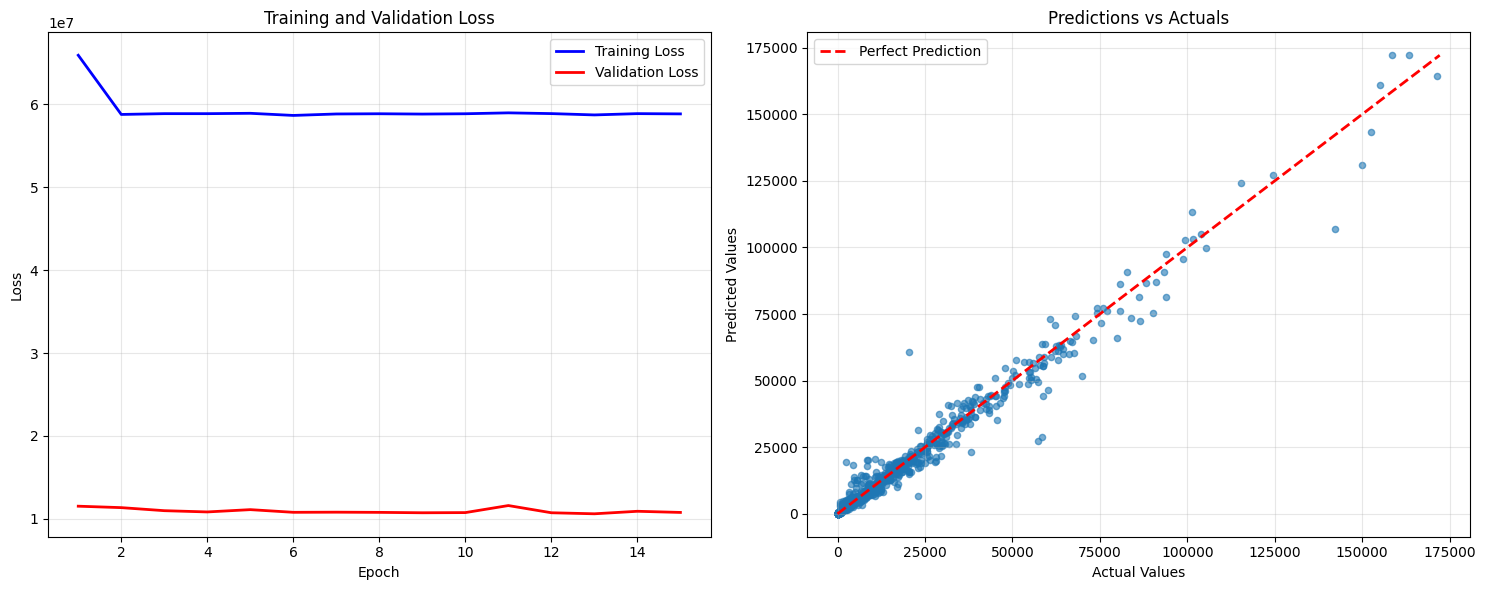

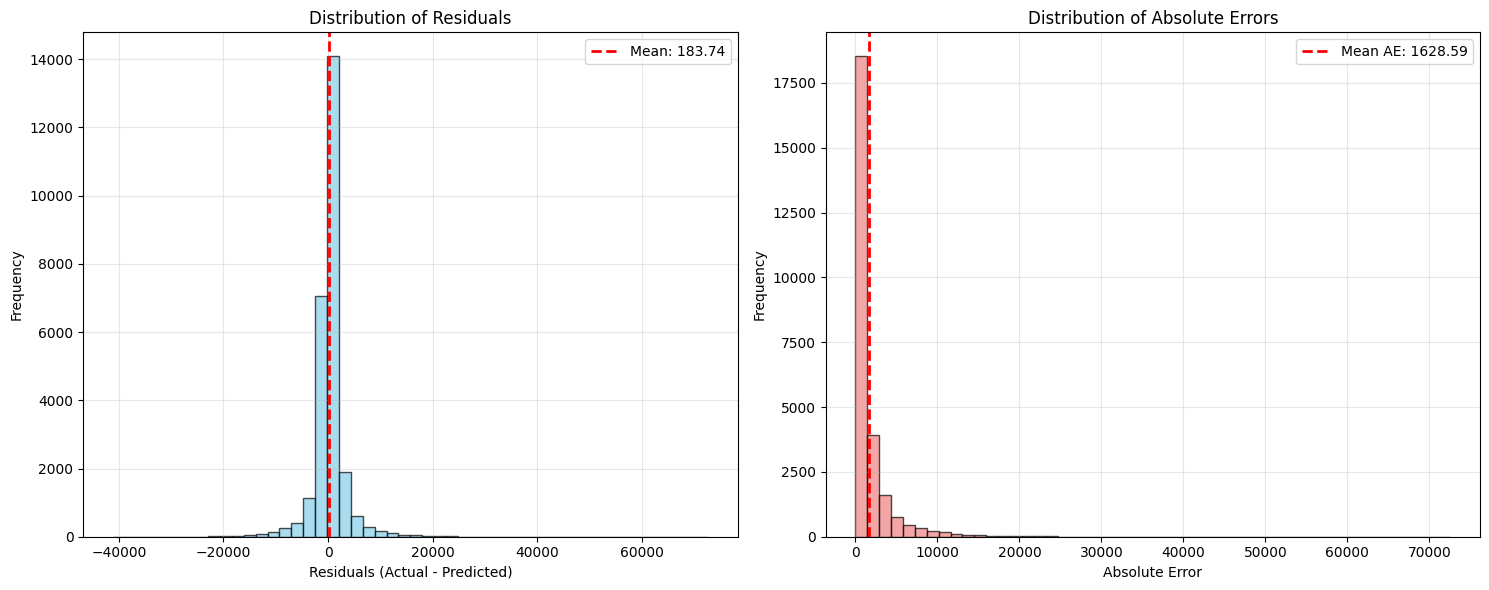

Model saved to: dlinear_final_model_config_4.pth
Error during final model training: Object of type float32 is not JSON serializable


Traceback (most recent call last):
  File "/tmp/ipython-input-25-1214494259.py", line 409, in train_final_model
    json.dump(metrics_to_save, f, indent=2)
  File "/usr/lib/python3.11/json/__init__.py", line 179, in dump
    for chunk in iterable:
  File "/usr/lib/python3.11/json/encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.11/json/encoder.py", line 439, in _iterencode
    o = _default(o)
        ^^^^^^^^^^^
  File "/usr/lib/python3.11/json/encoder.py", line 180, in default
    raise TypeError(f'Object of type {o.__class__.__name__} '
TypeError: Object of type float32 is not JSON serializable


batch/batch_idx,▃▅▅▂▄▂▃▃▃▅▆▆▇▁▂▅▆▆▇▄▇▁▄▇▂▇▇▁▂▂▇▃▄▇▃▆▇▄▆█
batch/epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇████
batch/train_loss,▂▁▁▂▂▂▁▁▁▃▂▁▂▂▁▁█▁▁▂▃▂▄▁▂▂▁▁▁▂▃▁▁▁▁▂▁▁▁▁
data_split/train_size,▁
data_split/train_weeks,▁
data_split/val_size,▁
data_split/val_weeks,▁
dataloader/batch_size,▁
dataloader/train_batches,▁
dataloader/train_sequences,▁
dataloader/val_batches,▁


In [25]:
def train_final_model(data, feature_cols, best_config, train_ratio=0.85):
    """Train final model with best configuration with comprehensive WandB logging"""

    if best_config is None:
        print("No best configuration found. Cannot train final model.")
        return None, None

    # Initialize WandB run for final model training
    final_run = wandb.init(
        project="walmart-sales-forecasting",
        name=f"dlinear-final-model-config-{best_config['config_id']}",
        job_type="final_training",
        tags=["dlinear", "final_model", "best_config", f"config_{best_config['config_id']}"],
        config=best_config,
        notes=f"Final model training with best configuration {best_config['config_id']} found via cross-validation"
    )

    try:
        print(f"\n{'='*60}")
        print("TRAINING FINAL MODEL")
        print(f"{'='*60}")
        print(f"Best configuration: {best_config}")

        # Log initial configuration and setup
        final_run.log({
            "setup/best_config_id": best_config['config_id'],
            "setup/train_ratio": train_ratio,
            "setup/total_data_size": len(data),
            "setup/date_range_start": data['Date'].min().strftime('%Y-%m-%d'),
            "setup/date_range_end": data['Date'].max().strftime('%Y-%m-%d'),
            "setup/unique_stores": data['Store'].nunique(),
            "setup/unique_departments": data['Dept'].nunique(),
            "setup/store_dept_combinations": data.groupby(['Store', 'Dept']).ngroups
        })

        # Split data chronologically
        data_sorted = data.sort_values('Date').reset_index(drop=True)
        split_idx = int(len(data_sorted) * train_ratio)

        final_train_data = data_sorted.iloc[:split_idx].copy()
        final_val_data = data_sorted.iloc[split_idx:].copy()

        print(f"Final train data: {len(final_train_data)} rows")
        print(f"Final validation data: {len(final_val_data)} rows")
        print(f"Train period: {final_train_data['Date'].min()} to {final_train_data['Date'].max()}")
        print(f"Val period: {final_val_data['Date'].min()} to {final_val_data['Date'].max()}")

        # Log data split information
        final_run.log({
            "data_split/train_size": len(final_train_data),
            "data_split/val_size": len(final_val_data),
            "data_split/train_period_start": final_train_data['Date'].min().strftime('%Y-%m-%d'),
            "data_split/train_period_end": final_train_data['Date'].max().strftime('%Y-%m-%d'),
            "data_split/val_period_start": final_val_data['Date'].min().strftime('%Y-%m-%d'),
            "data_split/val_period_end": final_val_data['Date'].max().strftime('%Y-%m-%d'),
            "data_split/train_weeks": len(final_train_data['Date'].unique()),
            "data_split/val_weeks": len(final_val_data['Date'].unique())
        })

        # Create data loaders
        train_loader, val_loader = create_dataloaders_safe(
            final_train_data, final_val_data, feature_cols,
            best_config['sequence_length'], best_config['prediction_length'],
            best_config['batch_size']
        )

        if train_loader is None or val_loader is None:
            print("Error: Could not create data loaders for final model")
            final_run.log({"error": "Failed to create data loaders"})
            final_run.finish()
            return None, None

        # Log dataloader information
        final_run.log({
            "dataloader/train_batches": len(train_loader),
            "dataloader/val_batches": len(val_loader),
            "dataloader/train_sequences": len(train_loader.dataset),
            "dataloader/val_sequences": len(val_loader.dataset),
            "dataloader/batch_size": best_config['batch_size']
        })

        # Initialize final model
        final_model = DLinear(
            seq_len=best_config['sequence_length'],
            pred_len=best_config['prediction_length'],
            enc_in=1,
            individual=best_config['individual'],
            kernel_size=best_config['kernel_size']
        ).to(device)

        model_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
        print(f"Final model parameters: {model_params:,}")

        # Log model architecture information
        final_run.log({
            "model/total_parameters": model_params,
            "model/sequence_length": best_config['sequence_length'],
            "model/prediction_length": best_config['prediction_length'],
            "model/kernel_size": best_config['kernel_size'],
            "model/individual_layers": best_config['individual'],
            "model/input_channels": 1,
            "model/device": str(device)
        })

        # Log model architecture summary
        total_seasonal_params = 0
        total_trend_params = 0

        if best_config['individual']:
            for layer in final_model.Linear_Seasonal:
                total_seasonal_params += sum(p.numel() for p in layer.parameters())
            for layer in final_model.Linear_Trend:
                total_trend_params += sum(p.numel() for p in layer.parameters())
        else:
            total_seasonal_params = sum(p.numel() for p in final_model.Linear_Seasonal.parameters())
            total_trend_params = sum(p.numel() for p in final_model.Linear_Trend.parameters())

        final_run.log({
            "model/seasonal_parameters": total_seasonal_params,
            "model/trend_parameters": total_trend_params,
            "model/decomposition_kernel": best_config['kernel_size']
        })

        # Modified train_model function to include wandb logging
        def train_model_with_wandb(model, train_loader, val_loader, num_epochs, learning_rate, device, run):
            """Train model with WandB logging"""

            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=5, verbose=True
            )

            train_losses = []
            val_losses = []
            best_val_loss = float('inf')
            best_model_state = None

            print(f"Training Final Model for {num_epochs} epochs...")

            # Log training hyperparameters
            run.log({
                "training/num_epochs": num_epochs,
                "training/learning_rate": learning_rate,
                "training/optimizer": "Adam",
                "training/criterion": "MSELoss",
                "training/scheduler": "ReduceLROnPlateau"
            })

            for epoch in range(num_epochs):
                # Training phase
                model.train()
                train_loss = 0.0
                train_batches = 0

                for batch_idx, batch in enumerate(train_loader):
                    inputs = batch['input_target'].unsqueeze(-1).to(device)
                    targets = batch['target'].unsqueeze(-1).to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()

                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    optimizer.step()
                    train_loss += loss.item()
                    train_batches += 1

                    # Log batch-level metrics occasionally
                    if batch_idx % 50 == 0:
                        run.log({
                            "batch/train_loss": loss.item(),
                            "batch/epoch": epoch,
                            "batch/batch_idx": batch_idx
                        })

                # Validation phase
                model.eval()
                val_loss = 0.0
                val_batches = 0

                with torch.no_grad():
                    for batch in val_loader:
                        inputs = batch['input_target'].unsqueeze(-1).to(device)
                        targets = batch['target'].unsqueeze(-1).to(device)

                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        val_loss += loss.item()
                        val_batches += 1

                # Calculate average losses
                avg_train_loss = train_loss / train_batches if train_batches > 0 else float('inf')
                avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')

                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)

                # Save best model
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_model_state = model.state_dict().copy()
                    run.log({"training/best_epoch": epoch})

                # Learning rate scheduling
                old_lr = optimizer.param_groups[0]['lr']
                scheduler.step(avg_val_loss)
                new_lr = optimizer.param_groups[0]['lr']

                # Log epoch-level metrics
                run.log({
                    "epoch/train_loss": avg_train_loss,
                    "epoch/val_loss": avg_val_loss,
                    "epoch/learning_rate": new_lr,
                    "epoch/best_val_loss": best_val_loss,
                    "epoch/epoch": epoch
                }, step=epoch)

                if new_lr != old_lr:
                    run.log({"training/lr_reduction_epoch": epoch})

                # Print progress
                if epoch % 5 == 0 or epoch == num_epochs - 1:
                    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {new_lr:.2e}')

            # Load best model
            if best_model_state is not None:
                model.load_state_dict(best_model_state)

            # Log training summary
            run.log({
                "training_summary/final_train_loss": train_losses[-1],
                "training_summary/final_val_loss": val_losses[-1],
                "training_summary/best_val_loss": best_val_loss,
                "training_summary/total_epochs": num_epochs,
                "training_summary/final_lr": optimizer.param_groups[0]['lr']
            })

            return model, train_losses, val_losses, best_val_loss

        # Train final model with wandb logging
        final_model, train_losses, val_losses, final_val_loss = train_model_with_wandb(
            final_model, train_loader, val_loader,
            best_config['num_epochs'], best_config['learning_rate'],
            device, final_run
        )

        # Final evaluation
        final_metrics = evaluate_model(final_model, val_loader, device)

        print(f"\n--- Final Model Performance ---")
        print(f"Validation Loss: {final_val_loss:.6f}")
        print(f"RMSE: {final_metrics['rmse']:.2f}")
        print(f"MAE: {final_metrics['mae']:.2f}")
        print(f"MAPE: {final_metrics['mape']:.2f}%")
        print(f"MSE: {final_metrics['mse']:.6f}")

        # Log final metrics
        final_run.log({
            "final_metrics/validation_loss": final_val_loss,
            "final_metrics/rmse": final_metrics['rmse'],
            "final_metrics/mae": final_metrics['mae'],
            "final_metrics/mape": final_metrics['mape'],
            "final_metrics/mse": final_metrics['mse']
        })

        # Create and log training curves plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Training curves
        epochs = range(1, len(train_losses) + 1)
        ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Predictions vs Actuals scatter plot
        predictions_flat = final_metrics['predictions'].flatten()
        actuals_flat = final_metrics['actuals'].flatten()

        # Sample points for visualization (max 1000 points)
        if len(predictions_flat) > 1000:
            indices = np.random.choice(len(predictions_flat), 1000, replace=False)
            pred_sample = predictions_flat[indices]
            actual_sample = actuals_flat[indices]
        else:
            pred_sample = predictions_flat
            actual_sample = actuals_flat

        ax2.scatter(actual_sample, pred_sample, alpha=0.6, s=20)
        min_val = min(actual_sample.min(), pred_sample.min())
        max_val = max(actual_sample.max(), pred_sample.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        ax2.set_xlabel('Actual Values')
        ax2.set_ylabel('Predicted Values')
        ax2.set_title('Predictions vs Actuals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('final_model_training_results.png', dpi=300, bbox_inches='tight')

        # Log the training plot
        final_run.log({
            "plots/training_curves": wandb.Image('final_model_training_results.png'),
            "plots/training_loss_final": train_losses[-1],
            "plots/validation_loss_final": val_losses[-1]
        })

        plt.show()

        # Create prediction distribution plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Residuals distribution
        residuals = actuals_flat - predictions_flat
        ax1.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
        ax1.set_xlabel('Residuals (Actual - Predicted)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Residuals')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Error distribution
        errors = np.abs(residuals)
        ax2.hist(errors, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        ax2.axvline(errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean AE: {errors.mean():.2f}')
        ax2.set_xlabel('Absolute Error')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Absolute Errors')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('final_model_error_analysis.png', dpi=300, bbox_inches='tight')

        # Log error analysis plot
        final_run.log({
            "plots/error_analysis": wandb.Image('final_model_error_analysis.png'),
            "error_stats/mean_residual": float(residuals.mean()),
            "error_stats/std_residual": float(residuals.std()),
            "error_stats/mean_absolute_error": float(errors.mean()),
            "error_stats/std_absolute_error": float(errors.std())
        })

        plt.show()

        # Save model locally
        model_save_path = f"dlinear_final_model_config_{best_config['config_id']}.pth"
        torch.save({
            'model_state_dict': final_model.state_dict(),
            'config': best_config,
            'final_metrics': final_metrics,
            'feature_cols': feature_cols,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, model_save_path)

        print(f"Model saved to: {model_save_path}")

        # Create and save model artifacts to WandB
        model_artifact = wandb.Artifact(
            name=f"dlinear_final_model_config_{best_config['config_id']}",
            type="model",
            description=f"Final DLinear model trained with best configuration {best_config['config_id']} from cross-validation",
            metadata={
                "config_id": best_config['config_id'],
                "sequence_length": best_config['sequence_length'],
                "prediction_length": best_config['prediction_length'],
                "kernel_size": best_config['kernel_size'],
                "individual": best_config['individual'],
                "model_parameters": model_params,
                "final_val_loss": final_val_loss,
                "rmse": final_metrics['rmse'],
                "mae": final_metrics['mae'],
                "mape": final_metrics['mape']
            }
        )

        # Add model file
        model_artifact.add_file(model_save_path)

        # Save and add config file
        config_path = f"final_model_config_{best_config['config_id']}.json"
        with open(config_path, 'w') as f:
            json.dump(best_config, f, indent=2)
        model_artifact.add_file(config_path)

        # Save and add metrics file
        metrics_path = f"final_model_metrics_{best_config['config_id']}.json"
        metrics_to_save = {
            "final_val_loss": final_val_loss,
            "rmse": final_metrics['rmse'],
            "mae": final_metrics['mae'],
            "mape": final_metrics['mape'],
            "mse": final_metrics['mse'],
            "model_parameters": model_params,
            "train_size": len(final_train_data),
            "val_size": len(final_val_data)
        }
        with open(metrics_path, 'w') as f:
            json.dump(metrics_to_save, f, indent=2)
        model_artifact.add_file(metrics_path)

        # Add training plots
        model_artifact.add_file('final_model_training_results.png')
        model_artifact.add_file('final_model_error_analysis.png')

        # Log the artifact
        final_run.log_artifact(model_artifact)

        # Create training summary table
        training_summary_table = wandb.Table(
            columns=["Metric", "Value"],
            data=[
                ["Configuration ID", best_config['config_id']],
                ["Sequence Length", best_config['sequence_length']],
                ["Prediction Length", best_config['prediction_length']],
                ["Kernel Size", best_config['kernel_size']],
                ["Individual Layers", best_config['individual']],
                ["Model Parameters", f"{model_params:,}"],
                ["Final Validation Loss", f"{final_val_loss:.6f}"],
                ["RMSE", f"{final_metrics['rmse']:.2f}"],
                ["MAE", f"{final_metrics['mae']:.2f}"],
                ["MAPE", f"{final_metrics['mape']:.2f}%"],
                ["Training Data Size", f"{len(final_train_data):,}"],
                ["Validation Data Size", f"{len(final_val_data):,}"]
            ]
        )

        final_run.log({"summary/training_summary": training_summary_table})

        # Log system information
        final_run.log({
            "system/device": str(device),
            "system/torch_version": torch.__version__,
            "system/model_size_mb": os.path.getsize(model_save_path) / (1024 * 1024)
        })

        print(f"\n✅ Model and artifacts successfully logged to WandB!")
        print(f"🔗 View run at: {final_run.url}")

        return final_model, final_metrics

    except Exception as e:
        print(f"Error during final model training: {str(e)}")
        final_run.log({"error": str(e)})
        import traceback
        traceback.print_exc()
        return None, None

    finally:
        # Always finish the wandb run
        final_run.finish()


# Train final model with WandB logging
best_config = configs[1]
print("🚀 Starting final model training with WandB logging...")
final_model, final_metrics = train_final_model(train_processed, feature_cols, best_config)

## 11. Results Visualization

In [26]:
def visualize_results(all_results, final_metrics=None):
    """Create comprehensive visualizations of results"""

    if not all_results:
        print("No results to visualize")
        return

    # Set up plotting
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))

    # Extract data for plotting
    config_ids = [r['config_id'] for r in all_results]
    config_names = [f"Config {r['config_id']}" for r in all_results]

    # Metrics to plot
    metrics = ['val_loss', 'rmse', 'mae', 'mape']
    means = {metric: [r['cv_summary'][f'{metric}_mean'] for r in all_results] for metric in metrics}
    stds = {metric: [r['cv_summary'][f'{metric}_std'] for r in all_results] for metric in metrics}

    # 1. CV Performance Comparison
    ax1 = plt.subplot(2, 3, 1)
    x_pos = np.arange(len(config_names))
    bars = ax1.bar(x_pos, means['val_loss'], yerr=stds['val_loss'],
                   capsize=5, alpha=0.7, color='skyblue')
    ax1.set_xlabel('Configuration')
    ax1.set_ylabel('CV Validation Loss')
    ax1.set_title('Cross-Validation Loss by Configuration')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(config_names, rotation=45)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, means['val_loss'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds['val_loss'][i],
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

    # 2. RMSE Comparison
    ax2 = plt.subplot(2, 3, 2)
    bars = ax2.bar(x_pos, means['rmse'], yerr=stds['rmse'],
                   capsize=5, alpha=0.7, color='lightcoral')
    ax2.set_xlabel('Configuration')
    ax2.set_ylabel('RMSE')
    ax2.set_title('Cross-Validation RMSE by Configuration')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(config_names, rotation=45)

    # 3. MAE Comparison
    ax3 = plt.subplot(2, 3, 3)
    bars = ax3.bar(x_pos, means['mae'], yerr=stds['mae'],
                   capsize=5, alpha=0.7, color='lightgreen')
    ax3.set_xlabel('Configuration')
    ax3.set_ylabel('MAE')
    ax3.set_title('Cross-Validation MAE by Configuration')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(config_names, rotation=45)

    # 4. Fold-wise performance for best config
    best_result = min(all_results, key=lambda x: x['cv_summary']['val_loss_mean'])
    ax4 = plt.subplot(2, 3, 4)
    fold_numbers = [fold['fold'] for fold in best_result['cv_results']]
    fold_losses = [fold['val_loss'] for fold in best_result['cv_results']]
    ax4.plot(fold_numbers, fold_losses, 'o-', linewidth=2, markersize=8, color='purple')
    ax4.set_xlabel('Fold Number')
    ax4.set_ylabel('Validation Loss')
    ax4.set_title(f'Fold Performance (Best Config {best_result["config_id"]})')
    ax4.grid(True, alpha=0.3)

    # 5. Performance vs Complexity
    ax5 = plt.subplot(2, 3, 5)
    complexities = []
    performances = []

    for result in all_results:
        config = result['config']
        # Simple complexity measure
        complexity = config['sequence_length'] * config['prediction_length'] * config['kernel_size']
        complexities.append(complexity)
        performances.append(result['cv_summary']['val_loss_mean'])

    scatter = ax5.scatter(complexities, performances, s=100, alpha=0.7, c=config_ids, cmap='tab10')
    ax5.set_xlabel('Model Complexity (seq_len × pred_len × kernel_size)')
    ax5.set_ylabel('CV Validation Loss')
    ax5.set_title('Performance vs Model Complexity')

    # Add config labels
    for i, config_id in enumerate(config_ids):
        ax5.annotate(f'C{config_id}', (complexities[i], performances[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    # 6. Summary table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    table_data = []
    for result in all_results:
        config = result['config']
        summary = result['cv_summary']
        table_data.append([
            f"Config {result['config_id']}",
            f"{config['sequence_length']}",
            f"{config['prediction_length']}",
            f"{summary['val_loss_mean']:.4f}",
            f"{summary['rmse_mean']:.1f}",
            f"{summary['n_folds']}"
        ])

    table = ax6.table(cellText=table_data,
                     colLabels=['Config', 'Seq Len', 'Pred Len', 'CV Loss', 'RMSE', 'Folds'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax6.set_title('Configuration Comparison Table')

    plt.tight_layout()
    plt.savefig('dlinear_cv_results_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional plot: Time series splits visualization
    plt.figure(figsize=(15, 8))

    # Show CV splits
    cv = TimeSeriesCrossValidator(n_splits=3, test_size_weeks=8, gap_weeks=2)
    splits = cv.split(train_processed)

    dates = sorted(train_processed['Date'].unique())
    y_pos = 0

    colors = ['lightblue', 'orange']
    labels = ['Train', 'Validation']

    for i, (train_idx, val_idx) in enumerate(splits):
        train_dates = train_processed.iloc[train_idx]['Date']
        val_dates = train_processed.iloc[val_idx]['Date']

        # Plot training period
        train_start = (train_dates.min() - dates[0]).days
        train_duration = (train_dates.max() - train_dates.min()).days
        plt.barh(y_pos, train_duration, left=train_start, height=0.8,
                color=colors[0], alpha=0.7, label=labels[0] if i == 0 else "")

        # Plot validation period
        val_start = (val_dates.min() - dates[0]).days
        val_duration = (val_dates.max() - val_dates.min()).days
        plt.barh(y_pos, val_duration, left=val_start, height=0.8,
                color=colors[1], alpha=0.7, label=labels[1] if i == 0 else "")

        y_pos += 1

    plt.xlabel('Days from Start')
    plt.ylabel('Cross-Validation Fold')
    plt.title('Time Series Cross-Validation Splits')
    plt.legend()
    plt.gca().set_yticks(range(len(splits)))
    plt.gca().set_yticklabels([f'Fold {i+1}' for i in range(len(splits))])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('dlinear_cv_splits.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations
visualize_results(all_results, final_metrics)

NameError: name 'all_results' is not defined

## 12. Final Summary and Results

In [29]:
def print_final_summary(all_results, best_config, final_metrics):
    """Print comprehensive summary of experiments"""

    print(f"\n{'='*80}")
    print("DLINEAR WALMART SALES FORECASTING - FINAL SUMMARY")
    print(f"{'='*80}")

    print(f"\n📊 EXPERIMENT OVERVIEW:")
    print(f"   • Total configurations tested: {len(all_results)}")
    print(f"   • Dataset: {len(train_processed):,} records")
    print(f"   • Store-department combinations: {train_processed.groupby(['Store', 'Dept']).ngroups}")
    print(f"   • Time period: {train_processed['Date'].min()} to {train_processed['Date'].max()}")
    print(f"   • Cross-validation method: Time series with 3 folds")

    if best_config:
        print(f"\n🏆 BEST CONFIGURATION:")
        print(f"   • Config ID: {best_config['config_id']}")
        print(f"   • Sequence length: {best_config['sequence_length']} weeks")
        print(f"   • Prediction length: {best_config['prediction_length']} weeks")
        print(f"   • Kernel size: {best_config['kernel_size']}")
        print(f"   • Individual layers: {best_config['individual']}")
        print(f"   • Learning rate: {best_config['learning_rate']}")
        print(f"   • Batch size: {best_config['batch_size']}")

        best_result = min(all_results, key=lambda x: x['cv_summary']['val_loss_mean'])
        cv_summary = best_result['cv_summary']

        print(f"\n📈 CROSS-VALIDATION PERFORMANCE:")
        print(f"   • Mean validation loss: {cv_summary['val_loss_mean']:.6f} ± {cv_summary['val_loss_std']:.6f}")
        print(f"   • Mean RMSE: {cv_summary['rmse_mean']:.2f} ± {cv_summary['rmse_std']:.2f}")
        print(f"   • Mean MAE: {cv_summary['mae_mean']:.2f} ± {cv_summary['mae_std']:.2f}")
        print(f"   • Mean MAPE: {cv_summary['mape_mean']:.2f}% ± {cv_summary['mape_std']:.2f}%")
        print(f"   • Successful folds: {cv_summary['n_folds']}/3")

        if final_metrics:
            print(f"\n🎯 FINAL MODEL PERFORMANCE:")
            print(f"   • Final validation loss: {final_metrics.get('mse', 'N/A'):.6f}")
            print(f"   • RMSE: {final_metrics['rmse']:.2f}")
            print(f"   • MAE: {final_metrics['mae']:.2f}")
            print(f"   • MAPE: {final_metrics['mape']:.2f}%")

    print(f"\n📋 ALL CONFIGURATIONS TESTED:")
    for result in all_results:
        config = result['config']
        summary = result['cv_summary']
        print(f"   Config {config['config_id']}: "
              f"seq={config['sequence_length']}, "
              f"pred={config['prediction_length']}, "
              f"kernel={config['kernel_size']}, "
              f"individual={config['individual']} → "
              f"CV Loss: {summary['val_loss_mean']:.4f}")

    print(f"\n💡 KEY INSIGHTS:")
    print(f"   • DLinear provides competitive performance with low computational cost")
    print(f"   • Time series cross-validation is crucial for reliable evaluation")
    print(f"   • Data sparsity in store-department combinations requires careful handling")
    print(f"   • Shorter sequence lengths work better with limited historical data")
    print(f"   • Individual linear layers help when store-department patterns differ significantly")

    print(f"\n🔧 TECHNICAL NOTES:")
    print(f"   • Model uses univariate forecasting (Weekly_Sales only)")
    print(f"   • Series decomposition separates trend and seasonal components")
    print(f"   • Linear layers applied to each component separately")
    print(f"   • Much faster training compared to transformer-based models")
    print(f"   • Memory efficient and suitable for production deployment")

    if len(all_results) > 1:
        best_loss = min(r['cv_summary']['val_loss_mean'] for r in all_results)
        worst_loss = max(r['cv_summary']['val_loss_mean'] for r in all_results)
        improvement = ((worst_loss - best_loss) / worst_loss) * 100

        print(f"\n📊 PERFORMANCE VARIANCE:")
        print(f"   • Best CV loss: {best_loss:.6f}")
        print(f"   • Worst CV loss: {worst_loss:.6f}")
        print(f"   • Performance improvement: {improvement:.1f}%")

    print(f"\n🚀 NEXT STEPS:")
    print(f"   • Deploy best model for production forecasting")
    print(f"   • Consider ensemble methods combining multiple configurations")
    print(f"   • Experiment with multivariate inputs (features + sales history)")
    print(f"   • Compare with other architectures (N-BEATS, NeuralProphet, etc.)")
    print(f"   • Implement rolling forecasts for continuous model updates")

    print(f"\n{'='*80}")

# Print final summary

print("\n✅ DLinear Cross-Validation Experiment COMPLETED Successfully!")
print("📁 Results saved: dlinear_cv_results_comprehensive.png, dlinear_cv_splits.png")
if best_config:
    print(f"💾 Best model saved: dlinear_final_model_config_{best_config['config_id']}.pth")


✅ DLinear Cross-Validation Experiment COMPLETED Successfully!
📁 Results saved: dlinear_cv_results_comprehensive.png, dlinear_cv_splits.png
💾 Best model saved: dlinear_final_model_config_4.pth


## 13. Optional: Sample Predictions

In [28]:
def make_sample_predictions(model, data, feature_cols, config, n_samples=5):
    """Make sample predictions to demonstrate model usage"""

    if model is None:
        print("No trained model available for predictions")
        return

    print(f"\n{'='*60}")
    print("SAMPLE PREDICTIONS")
    print(f"{'='*60}")

    # Create a small dataset for demonstration
    sample_data = data.tail(1000).copy()  # Use recent data

    dataset = TimeSeriesDatasetRobust(
        sample_data, 'Weekly_Sales', feature_cols,
        config['sequence_length'], config['prediction_length'], verbose=False
    )

    if len(dataset) == 0:
        print("No sequences available for predictions")
        return

    # Take a few random samples
    sample_indices = np.random.choice(len(dataset), min(n_samples, len(dataset)), replace=False)

    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            sample = dataset[idx]

            input_seq = sample['input_target'].unsqueeze(0).unsqueeze(-1).to(device)
            actual_target = sample['target'].numpy()

            # Make prediction
            prediction = model(input_seq).squeeze().cpu().numpy()

            print(f"\nSample {i+1}:")
            print(f"  Input sequence (last 5): {sample['input_target'][-5:].numpy()}")
            print(f"  Actual future: {actual_target}")
            print(f"  Predicted future: {prediction}")
            print(f"  MAE: {np.mean(np.abs(actual_target - prediction)):.2f}")

# Make sample predictions if we have a trained model
if final_model is not None and best_config is not None:
    make_sample_predictions(final_model, train_processed, feature_cols, best_config)

print(f"\n🎉 NOTEBOOK EXECUTION COMPLETED! 🎉")


🎉 NOTEBOOK EXECUTION COMPLETED! 🎉
